# Anomally Detection using Autoencoders (ECG dataset)

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import msle
from tensorflow.keras.layers import Dropout, Dense

# Load Data

In [3]:
df = pd.read_csv("ecg.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [4]:
df.shape

(4998, 141)

In [5]:
features = df.drop(140,axis=1)
target = df[140]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create Autoencoder

In [8]:
class Autoencoder(Model):
    def __init__(self, outputs):
        super().__init__()
        self.encoder = Sequential([
            Dense(512, activation="relu"),
            Dropout(0.1),
            Dense(128, activation="relu"),
            Dropout(0.1),
            Dense(64, activation="relu")
        ])
        self.decoder = Sequential([
            Dense(64, activation="relu"),
            Dropout(0.1),
            Dense(128, activation="relu"),
            Dropout(0.1),
            Dense(512, activation="relu"),
            Dropout(0.1),
            Dense(outputs, activation="sigmoid")
        ])
    def call(self, inputs):
        code = self.encoder(inputs)
        return self.decoder(code)

In [9]:
model = Autoencoder(X_train.shape[1])
model.compile(loss="msle", optimizer="adam", metrics=["mse"])

In [10]:
e = 11
H = model.fit(X_train, X_train, validation_data=(X_test, X_test),epochs=e)

Epoch 1/11
125/125 [==============================] - 2s 6ms/step - loss: 0.0036 - mse: 0.0085 - val_loss: 0.0019 - val_mse: 0.0046
Epoch 2/11
125/125 [==============================] - 1s 5ms/step - loss: 0.0019 - mse: 0.0044 - val_loss: 0.0012 - val_mse: 0.0029
Epoch 3/11
125/125 [==============================] - 1s 5ms/step - loss: 0.0013 - mse: 0.0031 - val_loss: 8.5217e-04 - val_mse: 0.0021
Epoch 4/11
125/125 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0025 - val_loss: 8.6323e-04 - val_mse: 0.0021
Epoch 5/11
125/125 [==============================] - 1s 5ms/step - loss: 9.5407e-04 - mse: 0.0023 - val_loss: 7.2832e-04 - val_mse: 0.0018
Epoch 6/11
125/125 [==============================] - 1s 5ms/step - loss: 8.7923e-04 - mse: 0.0021 - val_loss: 6.3652e-04 - val_mse: 0.0016
Epoch 7/11
125/125 [==============================] - 1s 5ms/step - loss: 8.1249e-04 - mse: 0.0019 - val_loss: 6.1140e-04 - val_mse: 0.0015
Epoch 8/11
125/125 [========================

# Plot MSE loss

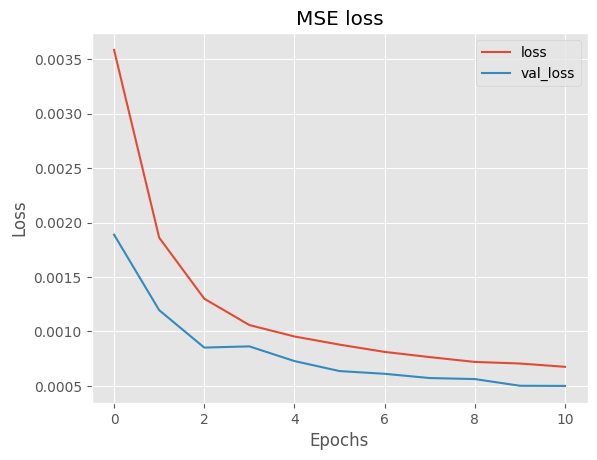

In [11]:
plt.style.use("ggplot")
plt.plot(np.arange(0,e), H.history["loss"], label="loss")
plt.plot(np.arange(0,e), H.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MSE loss")
plt.legend()

# Find Threshold

In [12]:
reconstructions = model(X_train)
reconstruction_errors = msle(reconstructions, X_train)

In [13]:
threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())

In [14]:
threshold

0.001599844521174981

In [15]:
pred = model(X_test)
pred_errors = msle(pred, X_test)

In [16]:
out = []
for error in pred_errors:
    if error > threshold:
        out.append(0)
    else:
        out.append(1)

In [17]:
accuracy_score(out,Y_test)

0.608